In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)
import time
import pickle
from visco_aux import Ndpdti, dphidtaui_gov

$$ \Phi(\mathbf{\tau}_{NEQ}) = \Phi_1(I_1^2) + \Phi_2(I_1^2-3I_2) + \Phi_3(\tau_1) + \Phi_4(\tau_1 + \tau_2) + \Phi_5(\tau_1 + \tau_2 + \tau_3) + \Phi_6(-\tau_3) $$

where $\tau_1, \tau_2, \tau_3 = eig(\tau_{NEQ})$ s.t. $\tau_1 \ge \tau_2 \ge \tau_3$, $I_1 = tr(\tau_{NEQ}) = \tau_{1} + \tau_{2} + \tau_{3}$ and $I_2 = 1/2(I_1^2-2tr(\tau^2))$, then

$$ \frac{\partial \Phi}{\partial \tau_{NEQ}} = \frac{\partial \Phi}{\partial \tau_i} \frac{\partial \tau_i}{\partial \tau_{NEQ}} $$

## Training

In [2]:
n = 100
taui = np.random.normal(size=[n,3])*1000
dphidtaui = np.zeros_like(taui)
for i in range(n):
    dphidtaui[i] = dphidtaui_gov(taui[i])

inputs = taui
outputs = [dphidtaui[:,0], dphidtaui[:,1], dphidtaui[:,2]]

inpmean = np.mean(taui)
inpsd   = np.std(taui)
outmean = np.mean(outputs)
outsd   = np.std(outputs)

In [18]:
model = Ndpdti()
model.inp.mean = tf.Variable([[inpmean]], dtype=tf.float32)
model.inp.sd   = tf.Variable([[inpsd  ]], dtype=tf.float32)
model.out.mean = tf.Variable([[outmean]], dtype=tf.float32)
model.out.sd   = tf.Variable([[outsd  ]], dtype=tf.float32)
learning_rate = 0.01
model.compile(loss = 'MSE', optimizer = Adam(learning_rate = learning_rate))#, run_eagerly=True)

In [14]:
starttime = time.time()
fit = model.fit(inputs, outputs, epochs = 100, batch_size = 5, verbose = 0, workers=8)
trtime = time.strftime('%H:%M:%S', time.gmtime(time.time() - starttime))
print('Training time: ', trtime)

Training time:  00:05:37


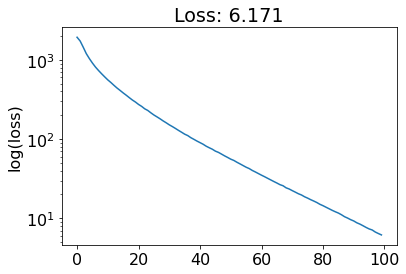

In [15]:
fig, ax = plt.subplots()
ax.plot(fit.history['loss'])
ax.set_yscale('log')
ax.set(title='Loss: {loss:.3f}'.format(loss = fit.history['loss'][-1]), ylabel='log(loss)')
pass

## Testing

In [2]:
# Load saved model
with open('saved/weights.pickle', 'rb') as f:
    weights = pickle.load(f)

n = 1000
taui = np.random.normal(size=[n,3])*10000
taui = -np.sort(-taui) #Sort taui in descending order
dphidtaui = np.zeros_like(taui)
for i in range(n):
    dphidtaui[i] = dphidtaui_gov(taui[i])

inputs = taui
outputs = [dphidtaui[:,0], dphidtaui[:,1], dphidtaui[:,2]]

# with open('saved/io.pickle', 'rb') as f:
#     inputs, outputs = pickle.load(f)
    
model = Ndpdti()
model.compile(loss = 'MSE', optimizer = Adam(learning_rate = 0.01))
model.set_weights(weights)

In [3]:
outputs_pred = np.array(model(inputs))

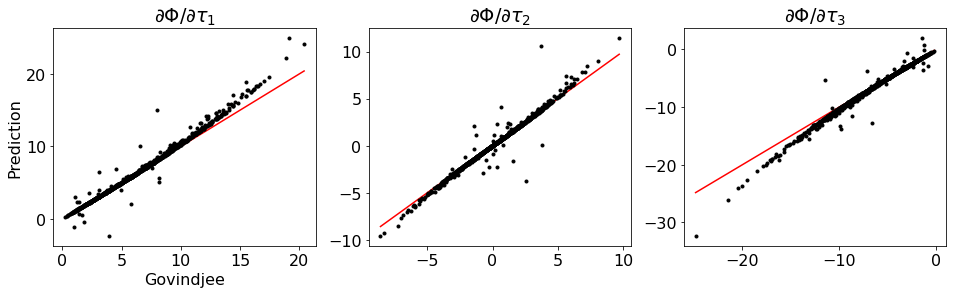

In [4]:
fig, ax = plt.subplots(1,3, figsize=[16,4])

names = [1,2,3]
for i in range(3):
    mx = np.max(outputs[i])
    mn = np.min(outputs[i])
    ax[i].plot([mn, mx], [mn, mx], 'r')
    ax[i].plot(outputs[i], outputs_pred[i], 'k.')
    ax[i].set(title='$\partial \Phi / \partial \\tau_{{ {s} }}$'.format(s = names[i]))#, xlim=[mn,mx], ylim=[mn,mx])
    
ax[0].set(xlabel='Govindjee', ylabel='Prediction')
pass

In [5]:
#-1964.3693470851929 -2061.978372990596 -2171.405430410435
tau1 = -4000
tau2 = -4000
tau3 = -4000

test = np.array([tau1, tau2, tau3], ndmin=2, dtype=np.float32)
gt = dphidtaui_gov(test[0])
pr = np.array(model(test))
print('Ground truth: [{g1:.5f} {g2:.5f} {g3:.5f}] \n Predictions: {pred}'.format(g1=gt[0], g2=gt[1], g3=gt[2], pred=pr[:,0,0]))

Ground truth: [-0.01524 -0.01524 -0.01524] 
 Predictions: [ 0.03600604 -0.01820345 -0.07271798]


# Gradients

In [5]:
import tensorflow.keras.backend as K
import tensorflow as tf

In [76]:
tau = np.array([5.5,10,3.3])
order = np.argsort(-tau)
tau1, tau2, tau3 = tau[order]
inputs = tf.Variable([[tau2, tau1, tau3]], dtype=tf.float32)
with tf.GradientTape(persistent=True) as g:
    g.watch(inputs)
    dphidtaui = model(inputs)
grad1 = g.gradient(dphidtaui[0], inputs) #dphidtau1dtau1, dphidtau1dtau2, dphidtau1dtau3
grad2 = g.gradient(dphidtaui[1], inputs)
grad3 = g.gradient(dphidtaui[2], inputs)

d2phid2tau = np.array([grad1, grad2, grad3])

In [77]:
test = np.array([grad1, grad2, grad3])
test = np.transpose(test, axes=[1,0,2])[0]
test.shape

(3, 3)

In [78]:
test

array([[2134.0242, 2059.1125, 2104.3425],
       [2059.1125, 2254.08  , 1984.1926],
       [2104.3425, 1984.1925, 2206.85  ]], dtype=float32)

In [82]:
print(tau1,tau2,tau3)

10.0 5.5 3.3


In [92]:
order

array([1, 0, 2])

In [89]:
grad1 = grad1[0].numpy()[order]
grad2 = grad2[0].numpy()[order]
grad3 = grad3[0].numpy()[order]

In [93]:
test = np.array([grad1, grad2, grad3])
test[order]

array([[2254.08  , 2059.1125, 1984.1926],
       [2059.1125, 2134.0242, 2104.3425],
       [1984.1925, 2104.3425, 2206.85  ]], dtype=float32)

In [7]:
taui = np.mgrid[-10000:10000:10j, -10000:10000:10j, -10000:10000:10j]
taui = taui.reshape([3,-1]).transpose()

taui = -np.sort(-taui)
dphidtaui = np.zeros_like(taui)
for i in range(taui.shape[0]):
    dphidtaui[i] = dphidtaui_gov(taui[i])

inputs = taui
outputs = [dphidtaui[:,0], dphidtaui[:,1], dphidtaui[:,2]]

starttime = time.time()
model = Ndpdti()
# np.mean(inputs)
# np.std(inputs)
# np.mean(outputs)
np.std(outputs)

3.832064734531483